Enter stock ticker symbol (e.g., AAPL): AAPL
Fetching live data for AAPL for the last 5 years...
Building and training LSTM model...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 0.0768
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0027
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0011
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 8.4549e-04
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - loss: 8.5520e-04
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 8.0724e-04
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 7.9323e-04
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 7.5910e-04
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 7.7366e-04
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 7.9475e-04
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 7.1922e-04
Epoch 12/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 7.0462e-04
Epoch 13/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 6.6913e-04
Epoch 14/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 6.8795e-04
Epoch 15/20
30/30 ━━━━━━━━

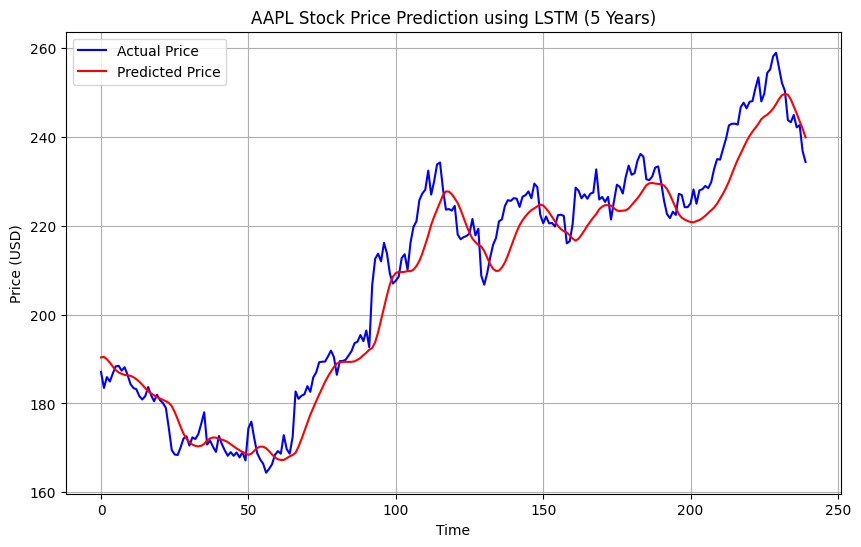

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Function to fetch live stock data
def fetch_stock_data(ticker, period="5y", interval="1d"):
    """
    Fetch live stock data using yfinance API.
    :param ticker: Stock ticker symbol (e.g., "AAPL" for Apple)
    :param period: Time period for data (e.g., "5y" for 5 years)
    :param interval: Time interval for data (e.g., "1d" for 1 day)
    :return: DataFrame with stock data
    """
    stock = yf.Ticker(ticker)
    data = stock.history(period=period, interval=interval)
    return data

# Function to preprocess data for LSTM
def preprocess_data(data, lookback=60):
    """
    Preprocess data for LSTM model.
    :param data: DataFrame with stock data
    :param lookback: Number of previous days to use for prediction
    :return: X (features), y (target), scaler (for inverse transform)
    """
    # Use only the 'Close' column
    close_prices = data['Close'].values.reshape(-1, 1)

    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(close_prices)

    # Create sequences for LSTM
    X, y = [], []
    for i in range(lookback, len(scaled_data)):
        X.append(scaled_data[i - lookback:i, 0])
        y.append(scaled_data[i, 0])
    X, y = np.array(X), np.array(y)

    # Reshape X to be compatible with LSTM input
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    return X, y, scaler

# Function to build LSTM model
def build_lstm_model(input_shape):
    """
    Build an LSTM model.
    :param input_shape: Shape of the input data (lookback, 1)
    :return: Compiled LSTM model
    """
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(units=25))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Function to calculate accuracy metrics
def calculate_accuracy(actual, predicted):
    """
    Calculate accuracy metrics for the predictions.
    :param actual: Actual stock prices
    :param predicted: Predicted stock prices
    :return: Dictionary with MAE, MSE, and RMSE
    """
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)

    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse
    }

# Function to plot stock data and predictions
def plot_stock_data(actual, predicted, ticker):
    """
    Plot actual and predicted stock prices.
    :param actual: Actual stock prices
    :param predicted: Predicted stock prices
    :param ticker: Stock ticker symbol
    """
    plt.figure(figsize=(10, 6))
    plt.plot(actual, color='blue', label='Actual Price')
    plt.plot(predicted, color='red', label='Predicted Price')
    plt.title(f'{ticker} Stock Price Prediction using LSTM (5 Years)')
    plt.xlabel('Time')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid()
    plt.show()

# Main function
def main():
    # Input stock ticker symbol
    ticker = input("Enter stock ticker symbol (e.g., AAPL): ").upper()

    # Fetch live stock data for 5 years
    print(f"Fetching live data for {ticker} for the last 5 years...")
    data = fetch_stock_data(ticker, period="5y", interval="1d")

    # Preprocess data for LSTM
    lookback = 60  # Use 60 days of data to predict the next day
    X, y, scaler = preprocess_data(data, lookback)

    # Split data into training and testing sets
    split = int(0.8 * len(X))  # 80% training, 20% testing
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # Build and train LSTM model
    print("Building and training LSTM model...")
    model = build_lstm_model((X_train.shape[1], 1))
    model.fit(X_train, y_train, batch_size=32, epochs=20)

    # Make predictions
    print("Making predictions...")
    predicted_prices = model.predict(X_test)
    predicted_prices = scaler.inverse_transform(predicted_prices)  # Inverse transform to actual prices
    actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))  # Actual prices

    # Calculate accuracy metrics
    accuracy = calculate_accuracy(actual_prices, predicted_prices)
    print(f"Accuracy Metrics for {ticker}:")
    print(f"Mean Absolute Error (MAE): {accuracy['MAE']:.2f}")
    print(f"Mean Squared Error (MSE): {accuracy['MSE']:.2f}")
    print(f"Root Mean Squared Error (RMSE): {accuracy['RMSE']:.2f}")

    # Plot actual vs predicted prices
    plot_stock_data(actual_prices, predicted_prices, ticker)

# Run the program
if __name__ == "__main__":
    main()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# New Section